# CAB420 Assignment 1B
- First Name: Aidan
- Last Name: Lockwood
- Student Number: 10515402

## Question 1: Person Re-Identification

In [13]:
# Importing the relevant libraries
import os 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import glob
import random

from sklearn import decomposition, discriminant_analysis
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay


## Step 1: Prepreprocessing

Utility functions used to preprocess the data - taken from the template

In [14]:
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

def split_validation(X, Y, id_cutoff = 250):

    train_X = X[Y <= id_cutoff, :]
    train_Y = Y[Y <= id_cutoff]

    val_X = X[Y > id_cutoff, :]
    val_Y = Y[Y > id_cutoff]

    return train_X, train_Y, val_X, val_Y

def sample_gallery_and_probe(X, Y):
    
    # storage
    gallery_X = []
    gallery_Y = []
    probe_X = []
    probe_Y = []

    # find unique IDs
    unique_ids = np.unique(Y)
    # loop through unique IDs
    for i in unique_ids:
        # pull out samples for the current ID
        samples = X[Y == i, :]
        # need at least two samples for use the ID
        if samples.shape[0] >= 2:
            # first sample for a subject stored in the gallery
            gallery_X.append(samples[0, :])
            gallery_Y.append(i)
            # second sample stored in the probe
            probe_X.append(samples[1, :])
            probe_Y.append(i)
            # any other images for the subject are ignored

    # return extracted data
    return np.array(gallery_X), np.array(gallery_Y), np.array(probe_X), np.array(probe_Y)

def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))
    # split validation data
    train_X, train_Y, val_X, val_Y = split_validation(train_X, train_Y)

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y

def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')

def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()

def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

(4711, 128, 64, 3)
(4711,)
(1222, 128, 64, 3)
(1222,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


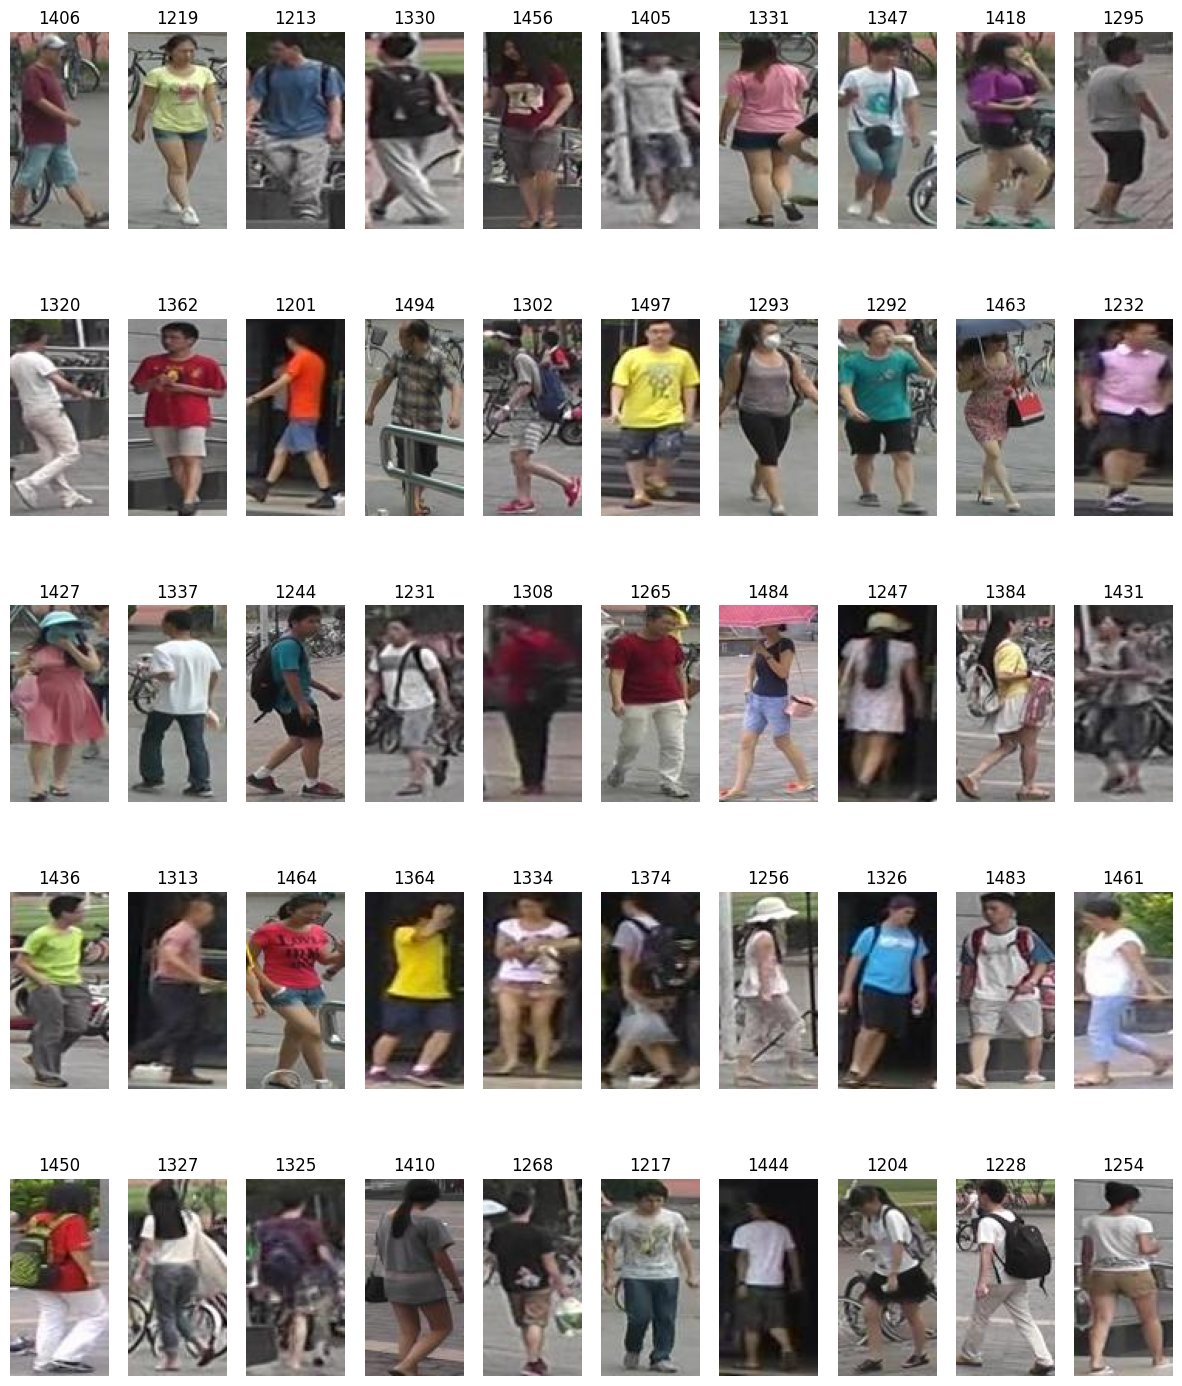

In [15]:
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('data/Q1/')

print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

plot_images(probe_X, probe_Y)


In [19]:
pca = decomposition.PCA()
train_X_vector = vectorise(train_X)

pca.fit(train_X_vector)
transformed_train_X = pca.transform(train_X_vector)

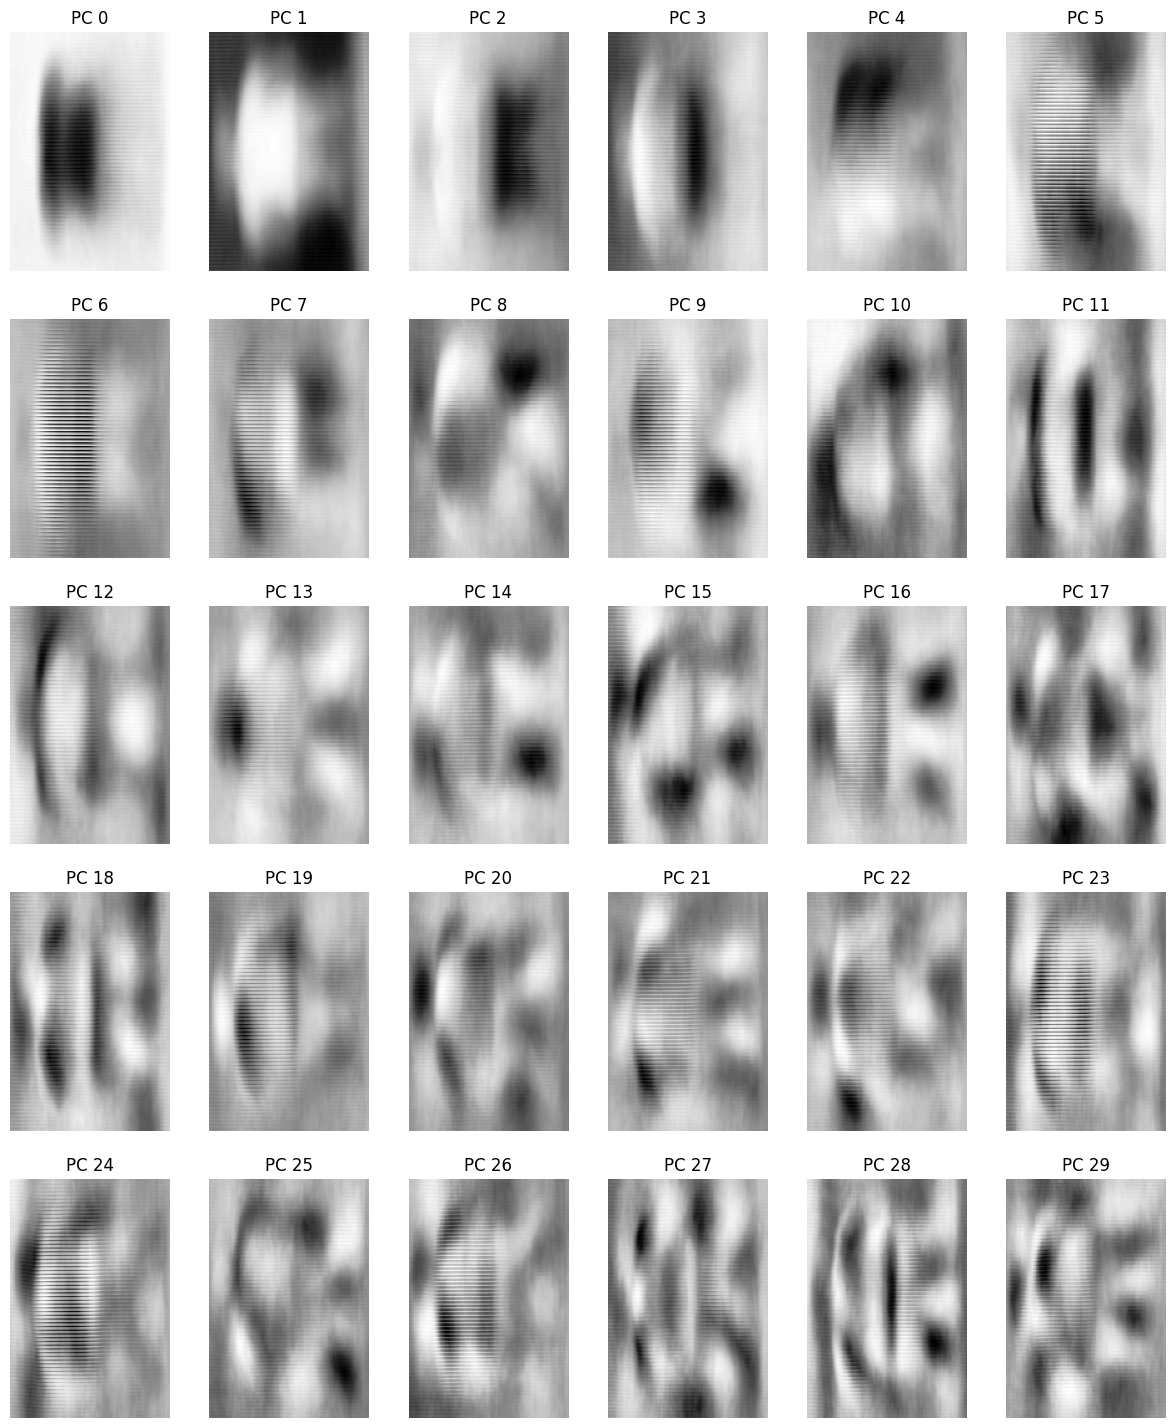

In [22]:
fig = plt.figure(figsize=[15, 18])

for i in range(30):
    ax = fig.add_subplot(5, 6, i + 1)
    pc = np.reshape(pca.components_[i, :], (128, 192))
    ax.imshow(pc.transpose(), cmap=plt.get_cmap('Greys'))
    ax.set_title('PC ' + str(i))
    ax.axis('off')